# Simple2D_DIC

Minimal tutorial to run **D2IC** on **2 images** (reference + deformed) and visualize the displacement field.

Data used: `doc/img/PlateHole/ohtcfrp_00.tif` (reference), `doc/img/PlateHole/ohtcfrp_10.tif` (deformed), and the ROI mask `doc/img/PlateHole/roi.tif`.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import sys

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread

from D2IC.dic import Dic
from D2IC.dic_plotter import DICPlotter
from D2IC import generate_roi_mesh


jax.config.update("jax_platform_name", "cpu")


jax.devices()

[CpuDevice(id=0)]

## 1) Load 2 images + ROI mask

im_ref: (1040, 400) float32
im_def: (1040, 400) float32
mask : (1040, 400, 4) uint8


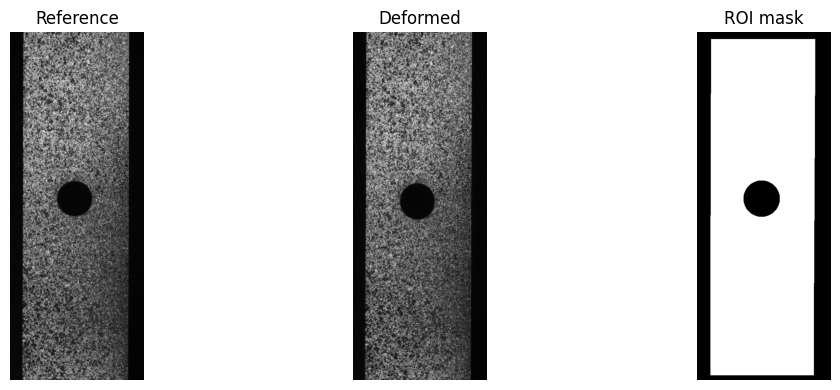

In [2]:

repo_root = None
current = Path.cwd().resolve()
for candidate in (current, *current.parents):
    img_root = candidate / "doc" / "img" / "PlateHole"
    if img_root.exists():
        repo_root = candidate
        break
if repo_root is None:
    raise FileNotFoundError(
        "Could not locate the repository root (doc/img/PlateHole folder missing)."
    )

img_dir = repo_root / "doc" / "img" / "PlateHole"
out_dir = Path("./_outputs")
out_dir.mkdir(exist_ok=True)

im_ref = imread(img_dir / "ohtcfrp_00.tif").astype(np.float32)
im_def = imread(img_dir / "ohtcfrp_10.tif").astype(np.float32)
mask = imread(img_dir / "roi.tif")

print("im_ref:", im_ref.shape, im_ref.dtype)
print("im_def:", im_def.shape, im_def.dtype)
print("mask :", mask.shape, mask.dtype)

fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
ax[0].imshow(im_ref, cmap="gray", origin="lower")
ax[0].set_title("Reference")
ax[1].imshow(im_def, cmap="gray", origin="lower")
ax[1].set_title("Deformed")
ax[2].imshow(mask, cmap="gray", origin="lower")
ax[2].set_title("ROI mask")
for a in ax:
    a.axis("off")
plt.tight_layout()


## 2) Generate an ROI mesh (from the mask)

The mesh is generated once and reused in subsequent runs.

In [3]:
mask_path = img_dir / "roi.tif"
mesh_path = out_dir / "Simple2D_DIC_roi_mesh_40px.msh"


mesh_path_generated = generate_roi_mesh(mask_path, element_size=20.0, msh_path=str(mesh_path))
if mesh_path_generated is None:
    raise RuntimeError("Mesh generation failed.")
mesh_path = Path(mesh_path_generated)

mesh_path

WindowsPath('_outputs/Simple2D_DIC_roi_mesh_40px.msh')

## 3) Create the DIC object

We precompute pixel-level quantities (on the reference image).

In [4]:
dic = Dic(mesh_path=str(mesh_path))
dic.precompute_pixel_data(jnp.asarray(im_ref))

dic

## 4) Estimate an initial displacement (big motion)

D2IC can estimate an initial field using sparse correspondences (patch matching + RANSAC).

Retained matches: 14


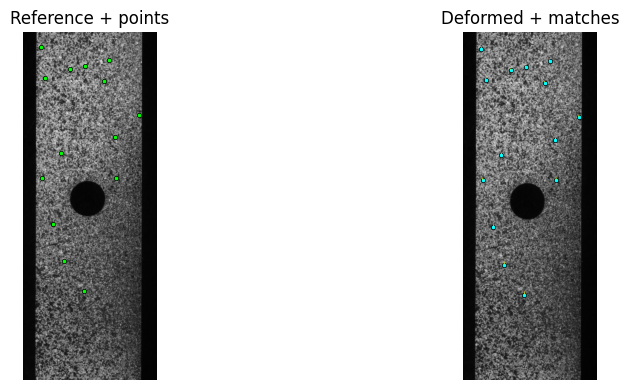

In [5]:
disp_guess, extras = dic.compute_feature_disp_guess_big_motion(
    im_ref,
    im_def,
    n_patches=32,
    patch_win=21,
    patch_search=15,
    refine=True,
    search_dilation=5.0,
)

pts_ref = extras["pts_ref"]
pts_def = extras["pts_def"]
print("Retained matches:", pts_ref.shape[0])

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
ax[0].imshow(im_ref, cmap="gray", origin="lower")
ax[0].scatter(pts_ref[:, 0], pts_ref[:, 1], s=10, c="lime", edgecolors="k", linewidths=0.5)
ax[0].set_title("Reference + points")

ax[1].imshow(im_def, cmap="gray", origin="lower")
ax[1].scatter(pts_def[:, 0], pts_def[:, 1], s=10, c="cyan", edgecolors="k", linewidths=0.5)
ax[1].quiver(
    pts_ref[:, 0],
    pts_ref[:, 1],
    pts_def[:, 0] - pts_ref[:, 0],
    pts_def[:, 1] - pts_ref[:, 1],
    angles="xy",
    scale_units="xy",
    scale=1.0,
    color="yellow",
    width=0.003,
)
ax[1].set_title("Deformed + matches")

for a in ax:
    a.axis("off")
plt.tight_layout()

## 5) Solve global DIC

Pixelwise solve with spring regularization (`reg_type="spring"`).

[CG] iter   0  J=9.1344e+02  ||g||=6.563e+00
        alpha=1.000e+00, J_new=8.8155e+02
[CG] iter   1  J=8.8155e+02  ||g||=3.470e+00
        alpha=1.000e+00, J_new=8.7168e+02
[CG] iter   2  J=8.7168e+02  ||g||=2.293e+00
        alpha=1.000e+00, J_new=8.6718e+02
[CG] iter   3  J=8.6718e+02  ||g||=1.679e+00
        alpha=1.000e+00, J_new=8.6468e+02
[CG] iter   4  J=8.6468e+02  ||g||=1.336e+00
        alpha=1.000e+00, J_new=8.6306e+02
[CG] iter   5  J=8.6306e+02  ||g||=1.115e+00
        alpha=1.000e+00, J_new=8.6191e+02
[CG] iter   6  J=8.6191e+02  ||g||=9.517e-01
        alpha=1.000e+00, J_new=8.6106e+02
[CG] iter   7  J=8.6106e+02  ||g||=8.640e-01
        alpha=1.000e+00, J_new=8.6034e+02
[CG] iter   8  J=8.6034e+02  ||g||=8.111e-01
        alpha=1.000e+00, J_new=8.5968e+02
[CG] iter   9  J=8.5968e+02  ||g||=8.032e-01
        alpha=1.000e+00, J_new=8.5904e+02
[CG] iter  10  J=8.5904e+02  ||g||=8.002e-01
        alpha=1.000e+00, J_new=8.5837e+02
[CG] iter  11  J=8.5837e+02  ||g||=8.156e-0

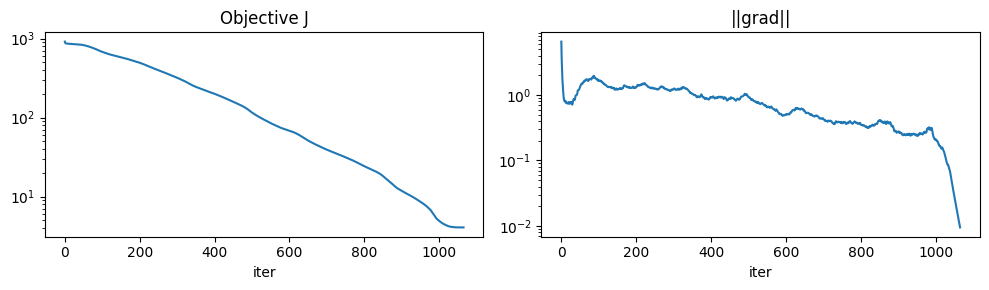

In [6]:
displacement, history = dic.run_dic(
    im_ref,
    im_def,
    disp_guess=disp_guess,
    max_iter=5000,
    tol=1e-2,
    reg_type="spring",
    alpha_reg=0.1,
)

hist = np.asarray(history)
print("Last state:", hist[-1])

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].semilogy(hist[:, 0])
ax[0].set_title("Objective J")
ax[0].set_xlabel("iter")
ax[1].semilogy(hist[:, 1])
ax[1].set_title("||grad||")
ax[1].set_xlabel("iter")
plt.tight_layout()

## 6) Visualize the displacement field

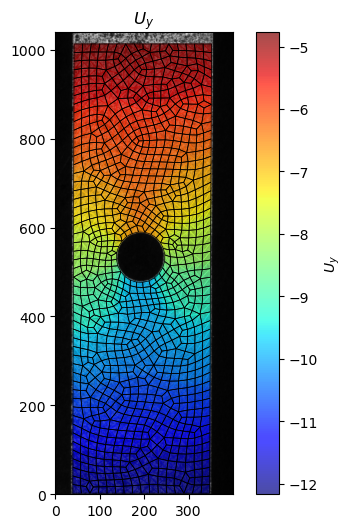

In [41]:
plotter = DICPlotter(
    background_image=im_def,
    displacement=np.asarray(displacement),
    dic_object=dic,
)

fig, _ = plotter.plot_displacement_component("Uy", image_alpha=0.7)
plt.show()

## 7) (Optional) Local nodal refinement 

To obtain a smoother field 

[Nodal-spring_jacobi] sweep 1/10, J=3.8154e+00
[Nodal-spring_jacobi] sweep 2/10, J=4.7275e+00
[Nodal-spring_jacobi] sweep 3/10, J=4.9078e+00
[Nodal-spring_jacobi] sweep 4/10, J=4.9918e+00
[Nodal-spring_jacobi] sweep 5/10, J=5.0284e+00
[Nodal-spring_jacobi] sweep 6/10, J=5.0488e+00
[Nodal-spring_jacobi] sweep 7/10, J=5.0611e+00
[Nodal-spring_jacobi] sweep 8/10, J=5.0692e+00
[Nodal-spring_jacobi] sweep 9/10, J=5.0746e+00
[Nodal-spring_jacobi] sweep 10/10, J=5.0785e+00


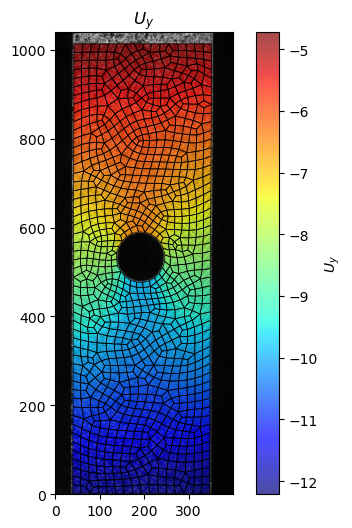

In [42]:
displacement_refined = dic.run_dic_nodal(
    im_ref,
    im_def,
    disp_init=displacement,
    n_sweeps=10,
    lam=0.1,
    reg_type="spring_jacobi",
    alpha_reg=1.0,
    max_step=0.2,
    omega_local=0.5,
)

plotter = DICPlotter(
    background_image=im_def,
    displacement=np.asarray(displacement_refined),
    dic_object=dic,
)
fig, _ = plotter.plot_displacement_component("Uy", image_alpha=0.7)
plt.show()

## 8 ) Estimate strains at the nodes

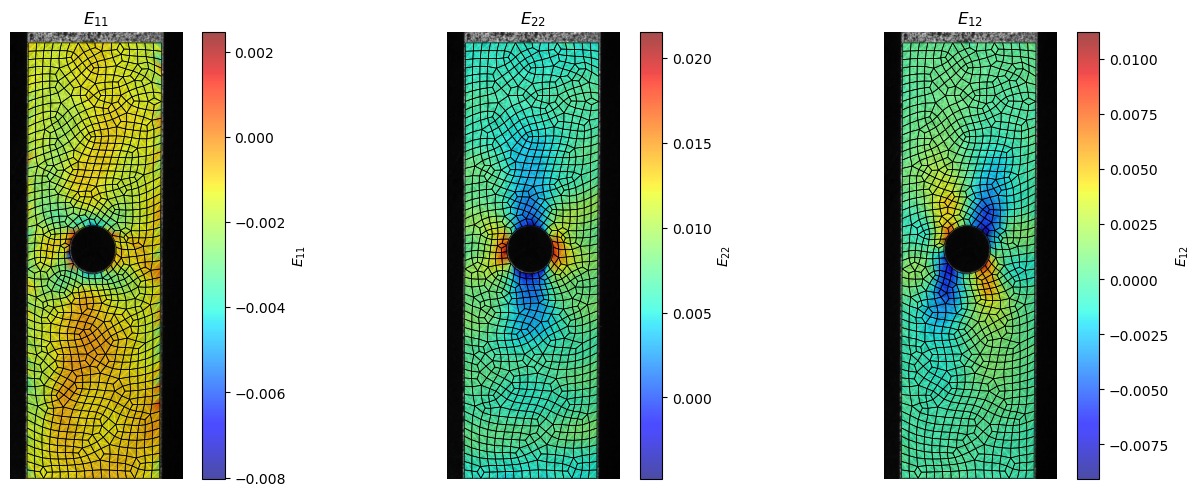

In [43]:

F_all, E_all = dic.compute_green_lagrange_strain_nodes(
    displacement_refined,
    k_ring=2,
    gauge_length=40.0,
)

plotter_strain = DICPlotter(
    background_image=im_def,
    displacement=displacement_refined,
    strain_fields=(F_all, E_all),
    dic_object=dic,
)

def plot_scalar_field(ax, values, title, cmap="jet", image_alpha=0.7):
    ax.imshow(plotter_strain.background_image, cmap="gray", origin="lower", alpha=1.0)
    mesh = ax.tripcolor(
        plotter_strain.triangulation,
        values,
        shading="gouraud",
        cmap=cmap,
        alpha=image_alpha,
        edgecolors="none",
        linewidth=0.0,
    )
    quad_mesh = plotter_strain._quad_mesh_collection()
    if quad_mesh is not None:
        ax.add_collection(quad_mesh)
    ax.set_aspect("equal")
    ax.set_title(title)
    ax.set_axis_off()
    return mesh

fields = [
    ("Exx", "Exx"),
    ("Eyy", "Eyy"),
    ("Exy", "Exy"),
]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
for ax, (field_name, _) in zip(axes, fields):
    values = plotter_strain.strain_fields[field_name]
    title = plotter_strain._latex_label(field_name, "strain")
    mesh = plot_scalar_field(ax, values, title)
    fig.colorbar(mesh, ax=ax, fraction=0.046, pad=0.04, label=title)

plt.tight_layout()
plt.show()
